In [3]:
# ==========================
# HackBio Stage 2: Single‑Cell RNA‑Seq Pipeline
# Dataset: Bone Marrow (.h5ad)
# Tools: Scanpy + Decoupler + PanglaoDB
# Author: Saumi Shah
# ==========================

import os
import urllib.request
import pandas as pd
import numpy as np
import urllib.parse

# -------------------------
# Install dependencies
# -------------------------
try:
    import scanpy as sc
except ImportError:
    !pip install scanpy
    import scanpy as sc

try:
    import decoupler as dc
except ImportError:
    !pip install --upgrade --force-reinstall decoupler
    import decoupler as dc

try:
    import igraph
except ImportError:
    !pip install python-igraph

try:
    import leidenalg
except ImportError:
    !pip install leidenalg

try:
    from pptx import Presentation
    from pptx.util import Inches, Pt
except ImportError:
    !pip install python-pptx
    from pptx import Presentation
    from pptx.util import Inches, Pt

import matplotlib.pyplot as plt
from IPython.display import FileLink # Keep FileLink for potential future use or debugging
from google.colab import files # Import files for automatic download

# -------------------------
# Optional plotting settings
# -------------------------
sc.settings.verbosity = 3
sc.logging.print_header()
sc.settings.set_figure_params(dpi=100, facecolor='white')

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 472.8/472.8 kB 9.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 175.3/175.3 kB 14.2 MB/s eta 0:00:00


In [4]:
# ==========================
# Function Definitions
# ==========================

def download_file(url, out_file):
    """Download file from url if it doesn't exist."""
    if not os.path.exists(out_file):
        print(f"Downloading {out_file}...")
        urllib.request.urlretrieve(url, out_file)
        print(f"Download complete: {out_file}")
    else:
        print(f"{out_file} already exists, skipping download.")

def load_h5ad(file_path):
    """Load AnnData object and print summary."""
    adata = sc.read_h5ad(file_path)
    print("Dataset loaded:")
    print(adata)
    return adata

def preprocess_adata(adata, min_genes=200, min_cells=3):
    """Perform QC, filtering, normalization, log1p, HVG selection, and scaling."""
    # Filter low-quality cells and genes
    sc.pp.filter_cells(adata, min_genes=min_genes)
    sc.pp.filter_genes(adata, min_cells=min_cells)

    # Identify mitochondrial genes and calculate QC metrics
    if any(adata.var_names.str.startswith("MT-")):
        adata.var["mt"] = adata.var_names.str.startswith("MT-")
        sc.pp.calculate_qc_metrics(adata, qc_vars=["mt"], inplace=True)
        adata = adata[adata.obs.n_genes_by_counts < 5000, :]
        adata = adata[adata.obs.pct_counts_mt < 10, :]

    # Normalize total counts per cell, log-transform
    sc.pp.normalize_total(adata, target_sum=1e4)
    sc.pp.log1p(adata)

    # Identify highly variable genes
    sc.pp.highly_variable_genes(adata, n_top_genes=2000, subset=True)
    sc.pp.scale(adata, max_value=10)
    print("Preprocessing complete.")
    return adata

In [10]:
def reduce_dimensions_and_cluster(adata, n_neighbors=10, n_pcs=40, leiden_resolution=0.5):
    """Compute PCA, neighbors, UMAP, and Leiden clustering."""
    sc.tl.pca(adata, svd_solver="arpack")
    sc.pp.neighbors(adata, n_neighbors=n_neighbors, n_pcs=n_pcs)
    sc.tl.umap(adata)
    sc.tl.leiden(adata, resolution=leiden_resolution)
    print("Dimensionality reduction and clustering complete.")
    return adata

def download_ensembl_mapping(mapping_file="ensembl_mapping.txt"):
    """Download Ensembl ID to gene symbol mapping from BioMart."""
    biomart_xml_query = (
        '<?xml version="1.0" encoding="UTF-8"?>' +
        '<!DOCTYPE Query>' +
        '<Query  virtualSchemaName = "default" formatter = "TSV" header = "0" uniqueRows = "0" count = "" datasetConfigVersion = "0.6" >' +
        '<Dataset name = "hsapiens_gene_ensembl" interface = "default" >' +
        '<Attribute name = "ensembl_gene_id" />' +
        '<Attribute name = "external_gene_name" />' +
        '</Dataset>' +
        '</Query>'
    )
    biomart_url = "http://www.ensembl.org/biomart/martservice?query=" + urllib.parse.quote(biomart_xml_query)
    download_file(biomart_url, mapping_file)
    ensembl_var = pd.read_csv(mapping_file, sep='\t', header=None)
    ensembl_var.columns = ["ensembl_gene_id", "gene_name"]
    print("Ensembl mapping loaded.")
    return ensembl_var

def get_panglao_markers(ensembl_var):
    """Get PanglaoDB markers and map to Ensembl IDs."""
    markers = dc.op.resource(name="PanglaoDB", organism="human")
    markers = markers[~markers.duplicated(["cell_type", "genesymbol"])]
    markers = markers.rename(columns={"cell_type": "source", "genesymbol": "target"})
    markers = markers[["source", "target"]]
    # Map to Ensembl
    markers = markers.merge(ensembl_var, left_on="target", right_on="gene_name", how="left")
    markers = markers.drop(columns=["target", "gene_name"])
    markers = markers[~markers.duplicated(["source", "ensembl_gene_id"])]
    markers = markers.rename(columns={"ensembl_gene_id": "target"})
    markers = markers[["source", "target"]].dropna()
    print("Markers mapped to Ensembl IDs.")
    return markers

In [6]:
def rank_genes_and_key_marker_expression(adata, ensembl_var):
    """Rank top genes per cluster and compute key lineage marker expression."""
    sc.tl.rank_genes_groups(adata, groupby="leiden", method="wilcoxon", pts=True)
    rg = adata.uns["rank_genes_groups"]
    # Print top 8 markers per cluster
    for g in adata.obs["leiden"].cat.categories:
        names = rg["names"][g][:8]
        print(f"Cluster {g} top markers: {', '.join(names)}")

    # Key lineage markers (evidence-driven selection)
    key_markers = [
        "CD34","GATA1","KLF1","HBB","MPO","ELANE","CSF1R","IL1B",
        "CD3D","CD4","CD8A","MS4A1","CD19","SDC1","MKI67","PF4",
        "PPBP","GZMB","PRF1","NKG7"
    ]
    key_markers_ensembl = ensembl_var[ensembl_var["gene_name"].isin(key_markers)]["ensembl_gene_id"].tolist()
    markers_present = [m for m in key_markers_ensembl if m in adata.var_names]

    expr = pd.DataFrame(index=adata.obs["leiden"].cat.categories, columns=markers_present, dtype=float)
    for cl in expr.index:
        cells = adata.obs_names[adata.obs["leiden"]==cl]
        expr.loc[cl] = adata[cells, markers_present].X.toarray().mean(axis=0) \
            if hasattr(adata.X, "toarray") else adata[cells, markers_present].X.mean(axis=0)
    print("Key lineage marker expression per cluster:\n", expr.round(3))
    return expr

def plot_umap_with_cell_types(adata, cell_type_dict):
    """
    Plot UMAP with readable cell type annotation labels.
    """
    # First, create the plot without displaying it immediately
    fig, ax = plt.subplots(figsize=(10, 8))
    sc.pl.umap(adata, color='leiden', legend_loc='on data', legend_fontsize=10, frameon=False, show=False, ax=ax)

    # Add labels manually at cluster centers
    for cl, label in cell_type_dict.items():
        # Ensure 'leiden' is a categorical and get the corresponding UMAP coordinates
        cluster_indices = adata.obs['leiden'] == cl
        if cluster_indices.any(): # Check if the cluster exists
            x = adata.obsm['X_umap'][cluster_indices, 0].mean()
            y = adata.obsm['X_umap'][cluster_indices, 1].mean()
            ax.text(x, y, label, fontsize=10, fontweight='bold', ha='center', va='center',
                     bbox=dict(facecolor='white', alpha=0.6, edgecolor='black', boxstyle='round'))

    ax.set_title("UMAP of Bone Marrow Cells with Cell Type Annotations")
    os.makedirs("figures", exist_ok=True)
    plt.savefig("figures/umap_clusters.png", dpi=150, bbox_inches='tight')
    plt.show()
    print("UMAP plotted with cell type labels.")

In [14]:
def save_linkedin_carousel_downloadable(adata, filename="HackBio_Stage2_SingleCell_Analysis.pptx"):
    prs = Presentation()

    # Slide 1 – Title
    slide = prs.slides.add_slide(prs.slide_layouts[5])
    slide.shapes.add_textbox(Inches(1), Inches(1), Inches(8), Inches(1.5)).text_frame.text = \
        "Bone Marrow Single-Cell RNA-Seq Analysis"
    slide.shapes.add_textbox(Inches(1), Inches(2), Inches(8), Inches(1)).text_frame.text = \
        "HackBio Stage 2 Project | Using Scanpy + Decoupler"
    slide.shapes.add_textbox(Inches(1), Inches(3), Inches(8), Inches(1)).text_frame.text = \
        "Author: Saumi Shah"

    # Slide 2 – UMAP
    slide = prs.slides.add_slide(prs.slide_layouts[5])
    slide.shapes.add_picture("figures/umap_clusters.png", Inches(1), Inches(1), width=Inches(8))
    slide.shapes.add_textbox(Inches(1), Inches(5.5), Inches(8), Inches(1)).text_frame.text = \
        "Cells clustered by Leiden algorithm (resolution=0.5) with cell type annotations"

    # Slide 3 – Predicted Cell Types
    slide = prs.slides.add_slide(prs.slide_layouts[5])
    slide.shapes.add_textbox(Inches(1), Inches(0.5), Inches(8), Inches(1)).text_frame.text = "Predicted Cell Types"

    predicted_cell_types = {
        '0': "Hematopoietic Stem/Progenitor Cells",
        '1': "Monocytes / Macrophages",
        '2': "Monocytes / Macrophages",
        '3': "NK Cells / Cytotoxic Lymphocytes",
        '4': "B Cells / Lymphocytes",
        '5': "Monocytes / Macrophages",
        '6': "Megakaryocytes / Platelets",
        '7': "NK Cells / Cytotoxic Lymphocytes",
        '8': "Erythroid Lineage Cells",
        '9': "NK Cells / Cytotoxic Lymphocytes",
        '10': "Erythroid Lineage Cells"
    }
    rows = len(predicted_cell_types)+1
    cols = 2
    table_shape = slide.shapes.add_table(rows, cols, Inches(1), Inches(1.5), Inches(6), Inches(4))
    table = table_shape.table
    table.cell(0,0).text = "Cluster"
    table.cell(0,1).text = "Predicted Cell Type"
    for i, (cl, ctype) in enumerate(predicted_cell_types.items()):
        table.cell(i+1,0).text = cl
        table.cell(i+1,1).text = ctype

    # Slide 4 – Biological Interpretation
    slide = prs.slides.add_slide(prs.slide_layouts[5])
    slide.shapes.add_textbox(Inches(1), Inches(0.5), Inches(8), Inches(1)).text_frame.text = "Biological Interpretation"
    bio_text = """Hematopoietic Stem/Progenitor Cells: give rise to all blood lineages
Monocytes/Macrophages: innate immune defense, phagocytosis, first responders
NK Cells: cytotoxic defense against infected/abnormal cells
B Cells: adaptive immunity, antibody production
Megakaryocytes/Platelets: blood clotting
Erythroid Cells: oxygen transport via hemoglobin"""
    slide.shapes.add_textbox(Inches(1), Inches(1.5), Inches(8), Inches(4)).text_frame.text = bio_text

    # Slide 5 – Key Insight
    slide = prs.slides.add_slide(prs.slide_layouts[5])
    slide.shapes.add_textbox(Inches(1), Inches(0.5), Inches(8), Inches(1)).text_frame.text = "Interesting Insight"
    slide.shapes.add_textbox(Inches(1), Inches(1.5), Inches(8), Inches(4)).text_frame.text = \
        "Largest cluster (28%) is enriched for HSPCs, indicating a strong progenitor population. Minor populations like nuocytes and first responders are also detectable, showing functional diversity."

    prs.save(filename)
    print(f"LinkedIn carousel saved as '{filename}'")
    files.download(filename) # Trigger immediate download

bone_marrow.h5ad already exists, skipping download.
Dataset loaded:
AnnData object with n_obs × n_vars = 14783 × 17374
    obs: 'disease stage', 'treatment', 'timepoint', 'Dataset', 'sample', 'disease_original', 'disease_general', 'COVID-19 Condition', 'Lineage', 'Cell.group', 'Cell.class_reannotated', 'n_genes', 'n_counts', 'percent_mito', 'tissue_original', 'tissue_ontology_term_id', 'disease_ontology_term_id', 'donor_id', 'development_stage_ontology_term_id', 'assay_ontology_term_id', 'cell_type_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'sex_ontology_term_id', 'is_primary_data', 'suspension_type', 'tissue_type', 'assay', 'disease', 'sex', 'tissue', 'self_reported_ethnicity', 'development_stage', 'observation_joinid'
    var: 'n_cells', 'feature_is_filtered', 'feature_name', 'feature_reference', 'feature_biotype', 'feature_length', 'feature_type'
    uns: 'citation', 'doi', 'organism', 'organism_ontology_term_id', 'schema_reference', 'schema_version', 'title'
   

/usr/lib/python3.12/functools.py:912: UserWarning: zero-centering a sparse array/matrix densifies it.
  return dispatch(args[0].__class__)(*args, **kw)


Preprocessing complete.
computing PCA
    with n_comps=50
    finished (0:00:18)
computing neighbors
    using 'X_pca' with n_pcs = 40
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:04)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm)
    'umap', UMAP parameters (adata.uns) (0:00:11)
running Leiden clustering
    finished: found 10 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:04)
Dimensionality reduction and clustering complete.
Download complete: ensembl_mapping.txt
Ensembl mapping loaded.
Markers mapped to Ensembl IDs.
ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray

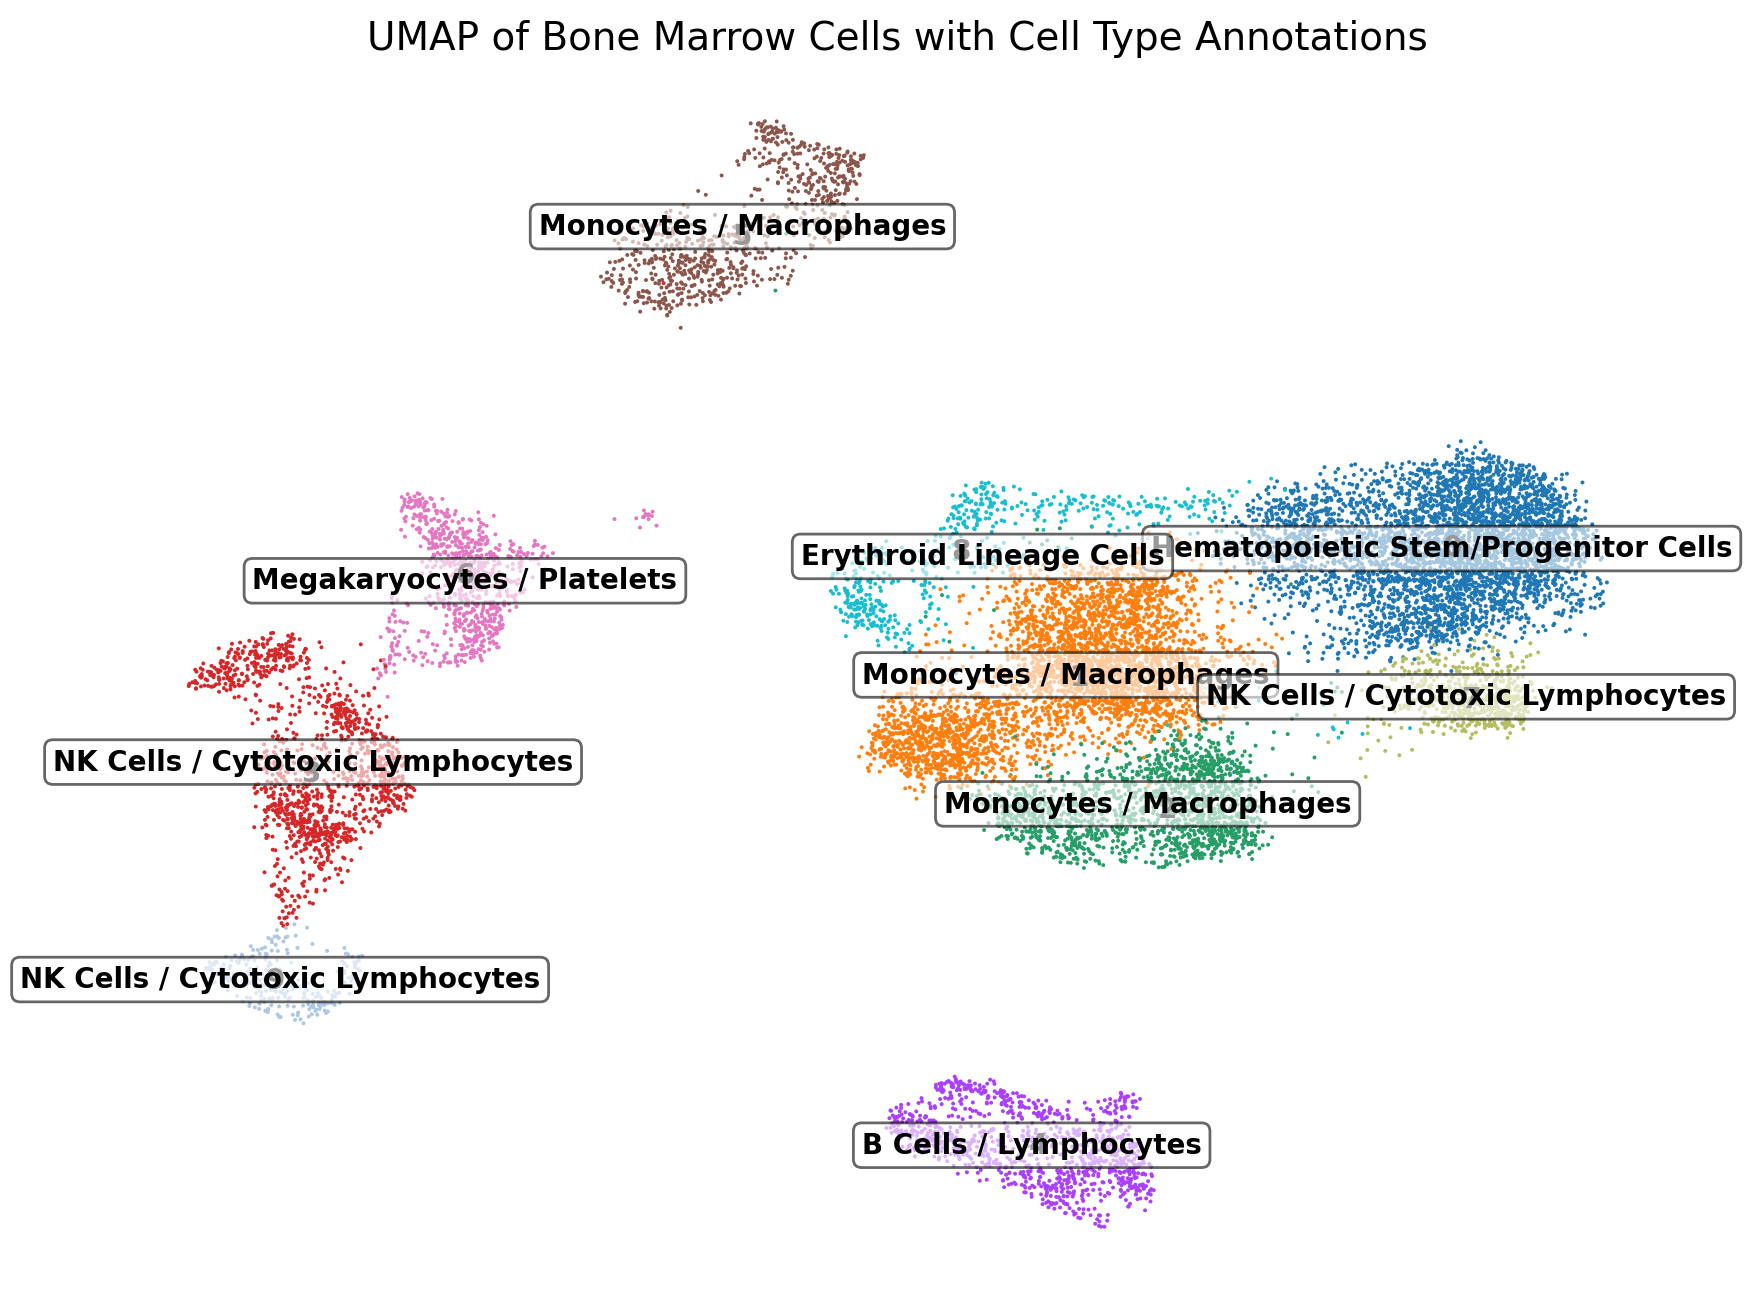

UMAP plotted with cell type labels.
LinkedIn carousel saved as 'HackBio_Stage2_SingleCell_Analysis.pptx'


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [15]:
# ==========================
# Main Workflow
# ==========================

# 1. Download dataset
download_file("https://github.com/josoga2/sc/raw/refs/heads/main/bone_marrow.h5ad", "bone_marrow.h5ad")

# 2. Load
adata = load_h5ad("bone_marrow.h5ad")

# 3. Preprocess
adata = preprocess_adata(adata)

# 4. Dimensionality reduction & clustering
adata = reduce_dimensions_and_cluster(adata)

# 5. Ensembl mapping
# Ensure fresh download of ensembl_mapping.txt
if os.path.exists("ensembl_mapping.txt"):
    os.remove("ensembl_mapping.txt")
ensembl_var = download_ensembl_mapping()

# 6. PanglaoDB markers
markers = get_panglao_markers(ensembl_var)

# 7. Rank genes & key marker expression
key_expr = rank_genes_and_key_marker_expression(adata, ensembl_var)

# 8. Plot UMAP with cell type annotations
predicted_cell_types = {
    '0': "Hematopoietic Stem/Progenitor Cells",
    '1': "Monocytes / Macrophages",
    '2': "Monocytes / Macrophages",
    '3': "NK Cells / Cytotoxic Lymphocytes",
    '4': "B Cells / Lymphocytes",
    '5': "Monocytes / Macrophages",
    '6': "Megakaryocytes / Platelets",
    '7': "NK Cells / Cytotoxic Lymphocytes",
    '8': "Erythroid Lineage Cells",
    '9': "NK Cells / Cytotoxic Lymphocytes",
    '10': "Erythroid Lineage Cells"
}
plot_umap_with_cell_types(adata, predicted_cell_types)

# 9. Save processed data
adata.write("bone_marrow_processed.h5ad")

# 10. Generate LinkedIn carousel with download link
save_linkedin_carousel_downloadable(adata)